# (1) Implement a dummy QCoDes instrument and perform a measurement

In [1]:
import qcodes

import numpy as np
import xarray as xr

## Implement a dummy instrument

In [2]:
import numpy.random
import time


# Instruments are children of qcodes.Instrument
class NoisyInstrument(qcodes.Instrument):
    # Initialize and add Parameters
    def __init__(self, name, **kwargs):
        super().__init__(name, **kwargs)

        self.complex_system = [(0, 0)]

        self.add_parameter(
            name="excitation",
            system=self.complex_system,
            parameter_class=self._Excitation,
            unit="Volt",
        )
        self.add_parameter(
            name="response",
            system=self.complex_system,
            parameter_class=self._Response,
            unit="volt",
        )

    # This function needs to be defined for each instrument for compatibility
    def get_idn(self):
        return {}

    # Implement a set-only parameter. Parameters are children of qcodes.Parameter
    class _Excitation(qcodes.Parameter):
        def __init__(self, name, system, **kwargs):
            super().__init__(name, **kwargs)

            self.system = system

        # set_raw implements the standard setter function
        def set_raw(self, value):
            self.system.append((time.time(), value))

    # Implement a get-only parameter
    class _Response(qcodes.Parameter):
        def __init__(self, name, system, delay=0.5, **kwargs):
            super().__init__(name, **kwargs)

            self.system = system
            self.delay = delay

        # get_raw implements the standard getter function
        def get_raw(self):
            system_before_delay = list(
                filter(lambda x: x[0] < (time.time() - self.delay), self.system)
            )
            new_value = system_before_delay[-1][1] + 2 * np.random.random_sample() - 1

            return new_value

## Add the instrument to a station

In [3]:
qcodes.Instrument.close_all()
noisy_instrument = NoisyInstrument("noisy_instrument")

station = qcodes.Station(noisy_instrument)

## Enable parameter monitoring

In [4]:
m = qcodes.Monitor(noisy_instrument.excitation, noisy_instrument.response)

## Directly control the instrument

In [5]:
noisy_instrument.response()

-0.660093563511515

In [6]:
noisy_instrument.excitation(123)

## Do a measurement with the instrument

### Initialize the database

In [7]:
from pathlib import Path

qcodes.initialise_or_create_database_at(str(Path.home()) + "/Downloads/my_db.db")

### Create the experiment

Each experiment can have multiple measurements attached to it

In [8]:
evaluating_excitation = qcodes.load_or_create_experiment(
    experiment_name="evaluating excitation", sample_name="virtual sample"
)

evaluating_excitation

evaluating excitation#virtual sample#1@/Users/maxbeer/Downloads/my_db.db
------------------------------------------------------------------------

### Directly perform a simple sweep

The `dond` utility allows for fast nD sweeps

Starting experimental run with id: 1. Using 'qcodes.dataset.do1d'


  0%|          | 0/100 [00:00<?, ?it/s]

(linear exitation #1@/Users/maxbeer/Downloads/my_db.db
 -----------------------------------------------------
 noisy_instrument_excitation - numeric
 noisy_instrument_response - numeric,
 (<Axes: title={'center': 'Run #1, Experiment evaluating excitation (virtual sample)'}, xlabel='excitation (Volt)', ylabel='response (volt)'>,),
 (None,))

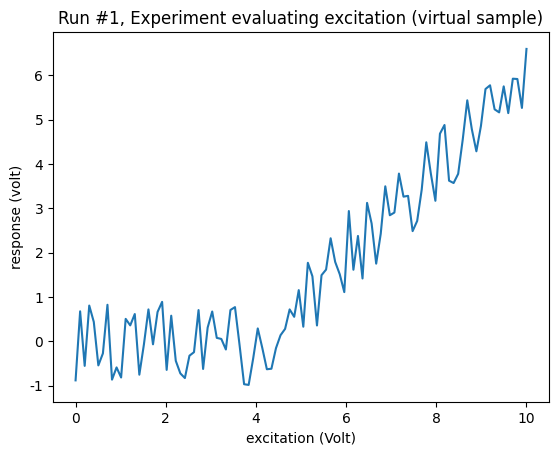

In [9]:
import qcodes.dataset

qcodes.dataset.do1d(
    noisy_instrument.excitation,
    0,  # start
    10,  # stop
    100,  # n_points
    0.01,  # delay
    noisy_instrument.response,
    measurement_name="linear exitation",
    exp=evaluating_excitation,
    do_plot=True,
    show_progress=True,
    enter_actions=[lambda: noisy_instrument.excitation(0), lambda: time.sleep(1)],
    exit_actions=[lambda: noisy_instrument.excitation(0)],
)

### Create another experiment

In [10]:
compensated_evaluating_excitation = qcodes.load_or_create_experiment(
    experiment_name="compensated evaluating excitation", sample_name="virtual sample"
)
compensated_evaluating_excitation

compensated evaluating excitation#virtual sample#2@/Users/maxbeer/Downloads/my_db.db
------------------------------------------------------------------------------------

### Create an ad-hoc parameter

In [11]:
t0 = time.time()

clock = qcodes.Parameter("clock", unit="seconds", get_cmd=lambda: time.time() - t0)

### Create a custom measurement

This creates the context manager generator `measurement` which provides a natural environment for a measurement.

In [12]:
measurement = qcodes.Measurement(
    exp=compensated_evaluating_excitation,
    station=station,
    name="linear excitation with wait",
)

measurement.register_parameter(clock)
measurement.register_parameter(noisy_instrument.excitation, setpoints=(clock,))
measurement.register_parameter(noisy_instrument.response, setpoints=(clock,))

measurement.add_before_run(lambda: time.sleep(1), args=())
measurement.add_after_run(lambda: noisy_instrument.excitation(0), args=[])

### Perform the measurement

In [13]:
with measurement.run() as datasaver:
    # Within this context data points can arbitrarily added to the datasaver

    for excitation_value in np.linspace(0, 10, 100):
        # Do something
        noisy_instrument.excitation(excitation_value)
        time.sleep(0.01)

        measurement = noisy_instrument.response()

        # Add data point
        datasaver.add_result(
            (clock, clock()),
            (noisy_instrument.excitation, excitation_value),
            (noisy_instrument.response, measurement),
        )

    t_end_sweep = time.time()

    while time.time() < t_end_sweep + 1:
        # Do something else
        time.sleep(0.01)

        measurement = noisy_instrument.response()

        # Add data point
        datasaver.add_result(
            (clock, clock()),
            (noisy_instrument.excitation, noisy_instrument.excitation()),
            (noisy_instrument.response, measurement),
        )

Starting experimental run with id: 2. 


### Inspect the resulting dataset

In [14]:
ds = compensated_evaluating_excitation.last_data_set()
ds

linear excitation with wait #2@/Users/maxbeer/Downloads/my_db.db
----------------------------------------------------------------
clock - numeric
noisy_instrument_excitation - numeric
noisy_instrument_response - numeric

([<Axes: title={'center': 'Run #2, Experiment compensated evaluating excitation (virtual sample)'}, xlabel='clock (seconds)', ylabel='excitation (Volt)'>,
  <Axes: title={'center': 'Run #2, Experiment compensated evaluating excitation (virtual sample)'}, xlabel='clock (seconds)', ylabel='response (volt)'>],
 [None, None])

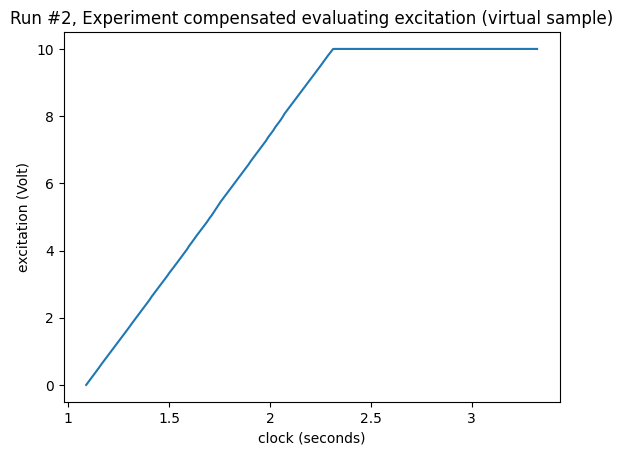

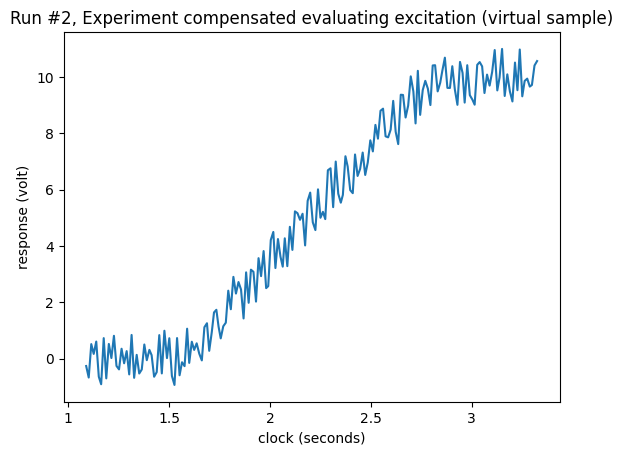

In [15]:
qcodes.dataset.plot_dataset(ds)